<a href="https://colab.research.google.com/github/adrinorosario/stellar-and-galactic-object-classification/blob/main/stellar_and_galactic_object_dataset_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stellar and Galactic Object Dataset Exploration

This project aims to detect and classify stellar and galactic objects such as stars, galaxies and quasars using photometric and spectral data. The goal of this notebook is to retrieve and analyse the data. Finally, as a deliverable, we will produce the data in the form of a CSV file (.csv) in order to agree with our project aim of building a model to work on tabular data.

The data will be collected/queried from [SDSS](https://skyserver.sdss.org/dr18/) which has mapped 1/3rd of the sky and has a good collection of the kind of data we need to produce a good classification model.

**Motivation:** The motivation behind this notebook is to serve as a playground or testing lab to learn more about the data we are dealing with. This is done to better understand what we are working with. Understanding the data, each column and what it refers to along with its relevance and relation to and in astronomy will serve as a good foundation to build better models and understand which data point is making a difference in our model's predictions.

**Initial plan:** To retrieve a small sample and analyse it before moving on to a larger and complex database.

First, import all the necessary packages. We will also be using the [astroquery](https://astroquery.readthedocs.io/en/latest/index.html) package from [astropy](https://www.astropy.org/), which is a python package for researchers and developers working in astronomy and related fields/projects.

Astroquery is a set of tools for querying astronomical web forms and databases. We will be using `astroquery.sdss` as a starting point for querying the data we require.

In [221]:
!python -m pip install -U --pre astroquery[all]

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import the SDSS module from astroquery.sdss
from astroquery.sdss import SDSS

# for dealing with coordinates
import astropy
from astropy import coordinates as coords

SDSS Class docs: https://astroquery.readthedocs.io/en/latest/api/astroquery.sdss.SDSSClass.html#astroquery.sdss.SDSSClass.query_region

In [278]:
# example to check if its working
pos = coords.SkyCoord('0h8m05.63s +14d50m23.3s', frame='icrs')
xid = SDSS.query_region(pos, radius='5 arcsec', spectro=True)
xid

ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d
float64,float64,uint64,int64,int64,int64,int64,float64,int64,int64,int64,uint64,int64
2.02344596573482,14.8398237551311,1237652943176138868,1739,301,3,315,0.04559058,751,52251,160,845594848269461504,26


In [224]:
qso_spec_temp = SDSS.get_spectral_template(kind="qso")
qso_spec_temp

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ebdcba8a910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ebdcaec2d90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ebdcbbdd910>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ebdcbbdedd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ebdcbb8c8d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ebdcbb8c690>]]

In [225]:
qso_spec_temp[0][1].data

FITS_rec([],
         dtype=(numpy.record, [('wave', '>f4'), ('waveErr', '>f4'), ('waveMin', '>f4'), ('waveMax', '>f4'), ('sigma', '>f4'), ('sigmaErr', '>f4'), ('sigmaMin', '>f4'), ('sigmaMax', '>f4'), ('height', '>f4'), ('heightErr', '>f4'), ('continuum', '>f4'), ('ew', '>f4'), ('ewErr', '>f4'), ('ewMin', '>f4'), ('specIndex', '>f4'), ('nsigma', '>f4'), ('chisq', '>f4'), ('nu', '>i4'), ('restWave', '>f4'), ('weight', '>f4'), ('z', '>f4'), ('zErr', '>f4'), ('lineMask', 'S1')]))

In [226]:
from astropy.table import Table
from astropy.modeling.models import Gaussian1D

In [227]:
for items in qso_spec_temp:
  for idx, item in enumerate(items):
    print(f"HDU{idx}: {type(item)} - {item.name}")
  print()

HDU0: <class 'astropy.io.fits.hdu.image.PrimaryHDU'> - PRIMARY
HDU1: <class 'astropy.io.fits.hdu.table.BinTableHDU'> - 
HDU2: <class 'astropy.io.fits.hdu.table.BinTableHDU'> - 
HDU3: <class 'astropy.io.fits.hdu.table.BinTableHDU'> - 
HDU4: <class 'astropy.io.fits.hdu.table.BinTableHDU'> - 
HDU5: <class 'astropy.io.fits.hdu.table.BinTableHDU'> - 



In [228]:
template = qso_spec_temp[0]
line_table = Table(template[1].data)

print(line_table.colnames)
print(line_table[:5])

# Step 4: Set up a wavelength grid (typical SDSS range: 3500–9200 Å)
wavelength = np.linspace(3500, 9200, 10000)
spectrum = np.zeros_like(wavelength)

['wave', 'waveErr', 'waveMin', 'waveMax', 'sigma', 'sigmaErr', 'sigmaMin', 'sigmaMax', 'height', 'heightErr', 'continuum', 'ew', 'ewErr', 'ewMin', 'specIndex', 'nsigma', 'chisq', 'nu', 'restWave', 'weight', 'z', 'zErr', 'lineMask']
wave waveErr waveMin waveMax sigma ... restWave weight  z  zErr lineMask
---- ------- ------- ------- ----- ... -------- ------ --- ---- --------


In [229]:
#add each spectral line as a gaussian
for row in line_table:
  if row['height'] <= 0 or row['sigma'] <= 0:
    continue
  g = Gaussian1D(amplitude=row['height'],
                 mean=row['wave'],
                 stddev=row['sigma'])
  spectrum += g(wavelength)

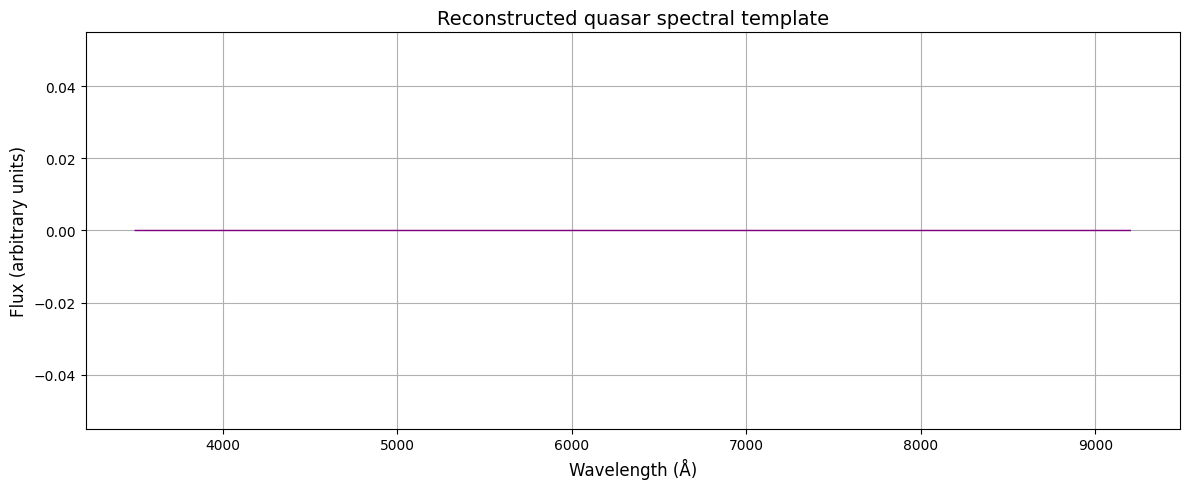

In [230]:
plt.figure(figsize=(12, 5))

plt.plot(wavelength, spectrum, lw=1, color="purple")
plt.xlabel("Wavelength (Å)", fontsize=12)
plt.ylabel("Flux (arbitrary units)", fontsize=12)
plt.title("Reconstructed quasar spectral template", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

## 1. Query a region

Now, we will attempt a query a region from the night sky. For a starting example, we will query the region of the [Stripe 82](https://www.physics.drexel.edu/~gtr/vla/stripe82/Deep_VLA_Observations_of_SDSS_Stripe_82.html), which is one of the most mapped parts of the night sky by SDSS.

The coordinates of Stripe 82 are RA range approximately -50 to +60 degrees, and Dec range -1.25 to +1.25 degrees. . You can find it [here](https://classic.sdss.org/legacy/stripe82.php).

**Note:** The coordinates stated above are _`Astronomical Sky Coordinates`_. However, there might be times when you need to convert the latitude and longitude to such sky coordinates. The coordinates, i.e., geographical coordinates should be converted into an astronomical sky coordinate. For that, we first need to understand how earth/geographical coordinates work compared to astronomical space coordinates. To learn more about that, refer the immediate code cells below or skip directly to querying the Stripe 82 region.

### 1.1. Understanding how coordinates work

For you who is standing at a point on earth, your location is indicated by a coordinate made up of a latitude and longitude.

To a person looking at the sky, the person it looking at a point which is measured by him in terms of Horizon coordinates, i.e., Altitude (up/down) and Azimuth (angle around the horizon).

Now, the exact coordinate of the particular object that the person is looking at is called the Astronomical Sky Coordinate or the Equitorial coordinates.

We obtain them using the following flow:


$ \frac{Latitude}{Longitude} + Time + \frac{Az}{At} \to SkyCoord (RA/Dec)$

The required inputs are:
- The latitude and longitude
- The time of the observation
- Direction in the sky:
  - If the person is looking straight up, At = $90^o$, Az is arbitrary.
  - Looking:
    - north = Az $0^o$
    - east = Az $90^o$
    - south = Az $180^o$
    - west = Az $270^o$

Understanding this, we will now create our function.

In [231]:
# EarthLocation is for setting the latitude and longitude coords, AltAx for calculating the Alt and Az values and SkyCoord takes in an AltAz value and converts it to a SkyCoord
from astropy.coordinates import EarthLocation, AltAz, SkyCoord

# for units
import astropy.units as u
# keeping consistent with the package time specifications
from astropy.time import Time

In [232]:
def geocoord_to_skycoord(latitude: float, longitude: float, height: float = 0.0) -> SkyCoord:

  # observer location records the current location of the person
  observer_location = EarthLocation(lat = latitude*u.deg, lon = longitude*u.deg, height = height*u.m)

  # set the observation time
  observation_time = Time("2025-05-05T00:00:00")

  # set the altitude and azimuth values
  altitude = 90 * u.deg
  azimuth = 0 * u.deg

  # calculate alt/az
  altaz = AltAz(location=observer_location, obstime=observation_time, alt=altitude, az=azimuth)

  # calculate skycoord
  skycoord = SkyCoord(altaz)

  return skycoord.icrs

In [233]:
# checking with the coordinates of the atacama dessert
atacama_dessert_sky_coord = geocoord_to_skycoord(latitude=-23.85913418, longitude=-69.12476276, height=2631.34)
atacama_dessert_sky_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (153.69706597, -23.72987314)>

Now, let us query the region of Messier31.



In [234]:
stripe82_center = SkyCoord(ra=5.0*u.degree, dec=0.0*u.degree, frame='icrs')
stripe82_center

<SkyCoord (ICRS): (ra, dec) in deg
    (5., 0.)>

In [257]:
patch_width = 2.0 * u.deg
patch_height = 2.0 * u.deg

try:
  region = SDSS.query_region(stripe82_center,
                             width=patch_width,
                             height=patch_height,
                             data_release=17, # the version of the data relase; e.g. DR17
                             photoobj_fields=['ra', 'dec', 'objid', 'u', 'g', 'r', 'i', 'z', 'type'], # photometric fields
                             specobj_fields=['z', 'specobjid', 'plate', 'mjd', 'fiberid', 'class', 'subclass'], # spectroscopic fields
                             spectro=True)
  if region:
    print(f"Found {len(region)} objects in the region")
    print(region[:5])
  else:
    print(f"No matching objects found in the region")

except Exception as e:
  print(f"Exception occured: {e}")

Found 8056 objects in the region
       ra               dec               objid        ... class    subclass 
---------------- ----------------- ------------------- ... ------ -----------
4.67382659420534 0.882522451909892 1237663278466662491 ...   STAR          M4
4.45384450461543 0.932756764128101 1237663278466597033 ... GALAXY   STARBURST
 4.7423948952673 0.837591485051322 1237657191981056014 ... GALAXY          --
4.59890689902417 0.990097280641725 1237663278466662547 ... GALAXY STARFORMING
4.71624710886516 0.901666588687589 1237663278466727942 ... GALAXY STARFORMING


In [258]:
type(region), region

(astropy.table.table.Table,
 <Table length=8056>
        ra               dec               objid        ... class    subclass 
     float64           float64             uint64       ...  str6     str21   
 ---------------- ----------------- ------------------- ... ------ -----------
 4.67382659420534 0.882522451909892 1237663278466662491 ...   STAR          M4
 4.45384450461543 0.932756764128101 1237663278466597033 ... GALAXY   STARBURST
  4.7423948952673 0.837591485051322 1237657191981056014 ... GALAXY          --
 4.59890689902417 0.990097280641725 1237663278466662547 ... GALAXY STARFORMING
 4.71624710886516 0.901666588687589 1237663278466727942 ... GALAXY STARFORMING
 4.61320554360154 0.932823991669338 1237663278466662552 ... GALAXY          --
 4.52513437885392 0.704892316722572 1237657191980925162 ... GALAXY STARFORMING
 4.50085662626628 0.767466724693421 1237657191980924995 ...    QSO   BROADLINE
 4.65369746589045 0.658553211417822 1237657191980990479 ... GALAXY   STARBURST
   

In [259]:
region_data = region.to_pandas()
region_data

,ra,dec,objid,u,g,r,i,z,type,z1,specobjid,plate,mjd,fiberid,class,subclass
0,4.673827,0.882522,1237663278466662491,24.63466,20.46730,19.16447,17.81142,17.27371,3,-0.000070,438140295498983424,389,51795,601,STAR,M4
1,4.453845,0.932757,1237663278466597033,19.68599,18.62956,18.23950,18.09357,18.06641,3,0.046935,438140845254797312,389,51795,603,GALAXY,STARBURST
2,4.742395,0.837591,1237657191981056014,19.57057,18.05848,17.32046,16.92774,16.63314,3,0.106070,438141120132704256,389,51795,604,GALAXY,NaN
3,4.598907,0.990097,1237663278466662547,19.64015,18.65812,18.04834,17.64224,17.47275,3,0.144899,438141395010611200,389,51795,605,GALAXY,STARFORMING
4,4.716247,0.901667,1237663278466727942,19.45905,18.06239,17.42848,17.01043,16.78838,3,0.088481,438141944766425088,389,51795,607,GALAXY,STARFORMING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8051,4.845874,0.617602,1237663277929857648,22.80808,22.65500,21.85090,20.81910,20.76705,3,7.042665,10595954384730085376,9411,58070,401,QSO,NaN
8052,4.712518,0.734965,1237657191980991516,18.51104,18.40119,21.66103,16.75225,27.42889,3,1.077518,10595954659607992320,9411,58070,402,QSO,NaN
8053,4.611394,0.986921,1237663278466662839,22.82442,22.81575,22.24055,21.63703,21.95746,6,0.755915,10595955484241713152,9411,58070,405,GALAXY,NaN
8054,4.617129,0.958051,1237663278466662855,23.68722,25.02959,21.70382,21.63189,22.80646,3,0.331870,10595955759119620096,9411,58070,406,GALAXY,NaN


In [260]:
region_data.columns

Index(['ra', 'dec', 'objid', 'u', 'g', 'r', 'i', 'z', 'type', 'z1',
       'specobjid', 'plate', 'mjd', 'fiberid', 'class', 'subclass'],
      dtype='object')

In [261]:
region_data['class'].unique()

array(['STAR', 'GALAXY', 'QSO'], dtype=object)

In [262]:
region_data['subclass'].unique(), len(region_data['subclass'].unique())

(array(['M4', 'STARBURST', nan, 'STARFORMING', 'BROADLINE', 'K5', 'M2',
        'L1', 'STARBURST BROADLINE', 'K7', 'AGN BROADLINE', 'A0', 'F2',
        'A0p', 'B9', 'M5', 'F5', 'AGN', 'M0', 'M8', 'M3', 'OB', 'WD', 'K3',
        'F9', 'CV', 'L0', 'M7', 'M6', 'G2', 'M1', 'G0', 'K1', 'M0V',
        'Carbon', 'G5', 'STARFORMING BROADLINE', 'M1 (204445)',
        'CalciumWD', 'M5III (221615)', 'F0IV (81937)', 'M6III (148783)',
        'WDhotter', 'G0Va (143761)', 'K5 (G_19-24)', 'M4.5:III (123657)',
        'Ldwarf', 'G0 (63791)', 'F3/F5V (30743)', 'K0V (10780)',
        'sd:F0 (G_84-29)', 'T2', 'F8V (30562)', 'F6V (16673)',
        'WDmagnetic', 'F0Ib (36673)', 'K0IV (191026)', 'K3V (32147)',
        'A1III (225180)', 'WDcooler', 'K5Ve (118100)', 'M3III (44478)',
        'F0V (90277)', 'K1IVa (142091)', 'B5 (338529)', 'G1V (95128)',
        'O8/O9 (167771)', 'Am (78362)', 'L5.5', 'A2II (39866)',
        'F8V (G_243-63)', 'F9IV (136064)', 'K5 (110281)', 'G8V (101501)',
        'A9V (154660)

In [263]:
region_data.isna().sum()

,0
ra,0
dec,0
objid,0
u,0
g,0
r,0
i,0
z,0
type,0
z1,0


In [264]:
no_subclass_regions = region_data[region_data["subclass"].isna()]
no_subclass_regions.head(5)

,ra,dec,objid,u,g,r,i,z,type,z1,specobjid,plate,mjd,fiberid,class,subclass
2,4.742395,0.837591,1237657191981056014,19.57057,18.05848,17.32046,16.92774,16.63314,3,0.106070,438141120132704256,389,51795,604,GALAXY,NaN
5,4.613206,0.932824,1237663278466662552,20.76590,18.81223,17.52304,16.99310,16.60506,3,0.173312,438142494522238976,389,51795,609,GALAXY,NaN
10,4.809297,0.717051,1237657191981056136,19.49188,17.92129,17.14732,16.75155,16.51404,3,0.097456,438144143789680640,389,51795,615,GALAXY,NaN
13,4.630628,0.811342,1237657191980990661,21.68114,20.38076,18.60013,17.97461,17.60404,3,0.329023,438144968423401472,389,51795,618,GALAXY,NaN
15,4.393630,0.743055,1237657191980859496,17.55625,15.66856,14.79713,14.39348,14.06773,3,0.044485,438145518179215360,389,51795,620,GALAXY,NaN


In [265]:
no_subclass_regions = no_subclass_regions.drop(['subclass'], axis=1)
no_subclass_regions.columns

Index(['ra', 'dec', 'objid', 'u', 'g', 'r', 'i', 'z', 'type', 'z1',
       'specobjid', 'plate', 'mjd', 'fiberid', 'class'],
      dtype='object')

In [266]:
region_data = region_data.dropna(subset=['subclass'])
region_data.shape

(4956, 16)

In [267]:
region_data.shape[0] + no_subclass_regions.shape[0]

8056

In [268]:
region_data.describe()

,ra,dec,objid,u,g,r,i,z,type,z1,specobjid,plate,mjd,fiberid
count,4956.000000,4956.000000,4.956000e+03,4956.000000,4956.000000,4956.000000,4956.000000,4956.000000,4956.000000,4956.000000,4.956000e+03,4956.000000,4956.000000,4956.000000
mean,5.011089,-0.031664,1.237660e+18,21.301550,19.437251,18.497107,17.883495,17.551150,5.298426,0.240006,2.183904e+18,1939.611582,53278.817191,346.106739
std,0.576447,0.577174,3.255276e+12,1.770589,1.459645,1.448493,1.466941,1.540260,1.269977,0.620126,2.487071e+18,2208.947450,1502.763273,203.298278
min,4.000273,-0.999864,1.237657e+18,15.124540,14.056550,13.240200,12.813650,12.520980,3.000000,-0.003330,4.379754e+17,389.000000,51782.000000,1.000000
25%,4.509417,-0.538694,1.237657e+18,20.067083,18.502520,17.566760,16.936890,16.535580,6.000000,-0.000070,1.226270e+18,1089.000000,52562.000000,174.000000
50%,5.032758,-0.051394,1.237663e+18,21.363585,19.456145,18.487165,17.770530,17.367125,6.000000,0.000035,1.261069e+18,1120.000000,52873.000000,332.000000
75%,5.515745,0.466159,1.237664e+18,22.593692,20.379047,19.235568,18.565963,18.275680,6.000000,0.085135,1.679909e+18,1492.000000,52932.000000,491.000000
max,5.999488,0.999329,1.237667e+18,26.346970,25.513880,25.146530,24.361810,22.868700,6.000000,4.349075,1.059592e+19,9411.000000,58070.000000,1000.000000


In [269]:
region_data["type"].value_counts()

,count
type,
6,3797
3,1159


In [270]:
region_data["type"].value_counts().sum()

np.int64(4956)

In [271]:
region_data["type"].unique()

array([3, 6])

In [272]:
region_data["class"].value_counts()

,count
class,
STAR,3273
GALAXY,1058
QSO,625


In [273]:
region_data["class"].value_counts().sum()

np.int64(4956)

Here, we can see that we have only 2 unique values for types:
- 3 which is a `Galaxy`
- 6 which is a `Star`
However, we cannot see a `1` which is for a `Quasar`.

But, when we check the class labels, we can see all the 3 different types of bodies, including Quasars indicated by `QSO`.

Now, in order to maintain consistency, we will reallocate the type labels to each record and bring the Quasar category into existence in the `type` column by using the data we have in the `class` column.

In [274]:
type_labels = {
    "QSO": 1,
    "GALAXY": 3,
    "STAR": 6
}

region_data["type"] = region_data["class"].map(type_labels)
region_data["type"].value_counts()

<ipython-input-274-984c23181d33>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_data["type"] = region_data["class"].map(type_labels)


,count
type,
6,3273
3,1058
1,625


In [275]:
region_data[['class', 'type']].head()

,class,type
0,STAR,6
1,GALAXY,3
3,GALAXY,3
4,GALAXY,3
6,GALAXY,3


In [276]:
region_data.head(3)

,ra,dec,objid,u,g,r,i,z,type,z1,specobjid,plate,mjd,fiberid,class,subclass
0,4.673827,0.882522,1237663278466662491,24.63466,20.46730,19.16447,17.81142,17.27371,6,-0.000070,438140295498983424,389,51795,601,STAR,M4
1,4.453845,0.932757,1237663278466597033,19.68599,18.62956,18.23950,18.09357,18.06641,3,0.046935,438140845254797312,389,51795,603,GALAXY,STARBURST
3,4.598907,0.990097,1237663278466662547,19.64015,18.65812,18.04834,17.64224,17.47275,3,0.144899,438141395010611200,389,51795,605,GALAXY,STARFORMING


In [277]:
region_data.columns

Index(['ra', 'dec', 'objid', 'u', 'g', 'r', 'i', 'z', 'type', 'z1',
       'specobjid', 'plate', 'mjd', 'fiberid', 'class', 'subclass'],
      dtype='object')

One thing which we can see here is that **colour indices** are missing.

### Colour indices and their importance
Colour indices are extremely important for our problem context and in astronomy as a whole. In simple words, it is `"the difference of magnitude measured of a stellar body through two different filters."`

A more intuitive way of thinking about it would be start with the human eyes. They perceive light in 3 main colour categories: red, blue and green. In the same way, the bodies floating on the endless horizon of the ocean we call space are read or observed through these different filters or magnitudes, each capturing a particular colour wavelength. Some of these are the photometric parameters that we can see in our dataset such as `u, g, r, i and z`, which are distinct filters through which the the light emitted by these galactic bodies are measured and observed.

The colour index is simply the difference between two magnitudes. Say that we have something like:

<center><big>$g - r$</big></center>

This is simply the difference between the green filter maginitude and the red filter magnitude.

### What is their use?

Well, colour indices are extremely powerful as, for one, they are used to observe the **colour** of a celestial body. This colour in turn tells us a lot about a body's **SED** or **Spectral Energy Distribution**.

There are a lot of definitions, ideas and _**uses**_ of SED.

One would be to think of it in the context of the brightness of stars and what that means. Hotter stars generally emit more `blue` light than red. Another way of thinking about it would be $g-r$, where the difference is the significantly more blue light and reduced green magnitude and larger red magnitude.

Making it even more simpler:

 $You \ are \ minusing \ Red \ (r) \ from \ Green \ (g). \ This \ leads \ to \ reduction \ in \ the \ value \ of \ g \ and \ thereby, \ makes \ it \ smaller \ compared \ to \ r \ and \ Blue \ (b).$


Another use would be in identifying what kind of body we are dealing with:
  - In stars, their SED is mainly concentrated in the brightness of light they emit, which is characterised by their temperature. The most hottest ones emit the most brightest blues and the least hottest ones emit red (_`this is a really trivial and simple way to understand it.`_). To put it more in a scientific manner: `the hotter the star is, the more its SED is shifted towards bluer wavelengths. Hence, the blue colour also.`

  - On the other hand, the brightness of galaxies is characterized by the brightness or light emitted but multitude of all its stars and maybe some cosmic dust and gas. Therefore, the SED is broader than that of stars.

  - Finally, in the case of quasars, **`they are significantly more brighter than stars!`**. Their SED is non-thermal owing to the acretion disk around the super-massive black hole as well as jets. Therfore, their SED is characterized more by **`redshifts`** than normal SED distributions as those of stars and galaxies. Since these bodies are so far off in space and we need to see back in time to observe them, their colour is not white as mostly perceived. It occupies a broad area on the colour space owing to the spread of light that occurs when it travels through space.

This brings us to an important topic: knowing the redshift of the bodies we are dealing with here"
* **Stars:** Colours are primarily determined by temperature. Redshift is low and almost 0 or negative ($z ≈ 0$).
* **Galaxies:** Colours are determined by the collective light emitted by stars and cosmic dust and gas, which significantly alter its redshift. Have moderate redshifts.
* **Quasars:** Colour determined by non-thermal SED's and high redshifts ($z \geq 0.5$).

### Usefulness in terms of Computation (in brief)

Colour indices offer mainly x number of advantages as follows in terms of computation:

* When we have $n$ number of photometric data points, it will be harder to work with all of them, by feeding all the different wavelengths into the model. Colour indices offer an easier and more efficient way of working through this.
* When plotted, the wavelengths of different bodies form differeng clusters:
  - Stars are more compactly placed.
  - Galaxies are more wider than that of stars.
  - Quasars occupy a vast region of the plot.

  Therefore, using colour indices helps the model in more efficient tracking and grouping of these clusters.
* It is cheaper to work with a few colour indices than tens or hundreds or even thousands of wavelength points.

**Extra:** Color indices are less sensitive to the overall brightness of an object and more sensitive to the relative distribution of light across wavelengths, making them useful even for faint objects. _~ Google Gemini_

Some of the fundamental ones are as follows:
* $u-g$
* $g-r$
* $r-i$
* $i-z$